In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as npp
from IPython.display import Video

# Add src to path
sys.path.append(str(Path(os.getcwd()).parent / "src"))

from phd.models.cm.analytical_plate import train, exact_solution, plot_results
# from phd.models.cm.plot_util import load_run_data, create_animation

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.

Enable just-in-time compilation with XLA.



## Forward Problem
We train the model to solve the linear elasticity PDE given boundary conditions.

In [7]:
# Configure and Train Forward Model
config_forward = {
    "task": "forward",
    "n_iter": 1000, # Short run for demonstration
    "log_every": 100,
    "generate_video": False, # We will generate it manually
    "save_fields_to_disk": True, # Do not save fields to disk during training
    "results_dir": "results_notebook",
    "net_type": "SPINN"
}

print("Training Forward Model...")
results_forward = train(config_forward)
run_dir_forward = Path(results_forward["run_dir"])
print(f"Training complete. Results available in memory.")

Training Forward Model...
Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 1.041565 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.78e+03, 2.62e+02, 2.80e-05, 3.25e+01, 4.83e-04]    [1.78e+03, 2.61e+02, 2.86e-05, 3.30e+01, 4.79e-04]    [1.14e+00]    
100       [4.09e+02, 9.32e+01, 1.93e+01, 1.00e+01, 1.16e+01]    [3.81e+02, 8.77e+01, 1.96e+01, 9.53e+00, 1.10e+01]    [6.78e-01]    
200       [3.50e+02, 7.98e+01, 9.65e+00, 3.73e+00, 6.06e+00]    [3.28e+02, 7.42e+01, 9.25e+00, 3.54e+00, 5.86e+00]    [6.40e-01]    
300       [2.61e+02, 4.56e+01, 6.02e+00, 3.70e+00, 7.79e+00]    [2.43e+02, 4.22e+01, 5.62e+00, 3.55e+00, 7.59e+00]    [6.83e-01]    
400       [2.69e+01, 1.06e+01, 2.98e+00, 5.69e+00, 7.44e+00]    [2.37e+01, 9.93e+00, 2.89e+00, 5.49e+00, 7.35e+00]    [6.19e-01]    
500       [7.86e+00, 3.65e+00, 1.43e+00, 1.76e+00, 7

### Forward Results Visualization
We generate the animation manually here to visualize the training progress.

W1126 17:44:30.799363   99359 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1126 17:44:30.802546   99189 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


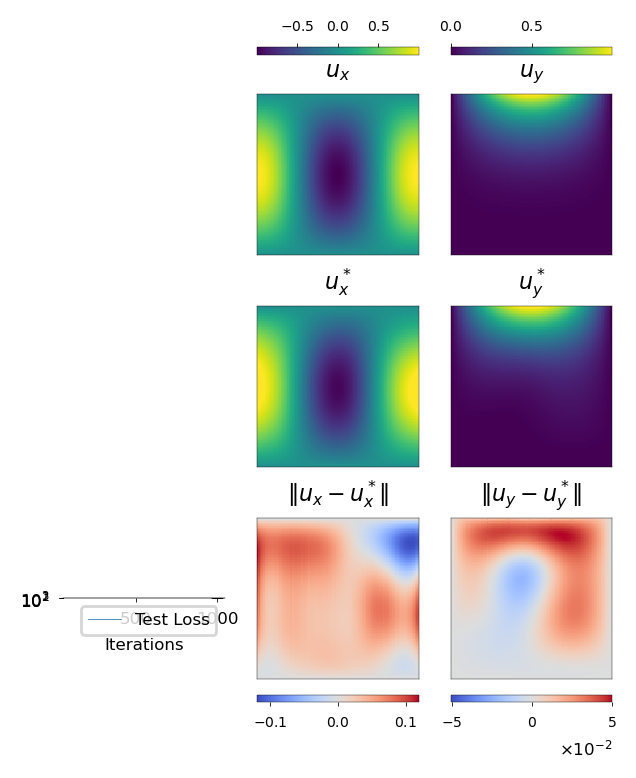

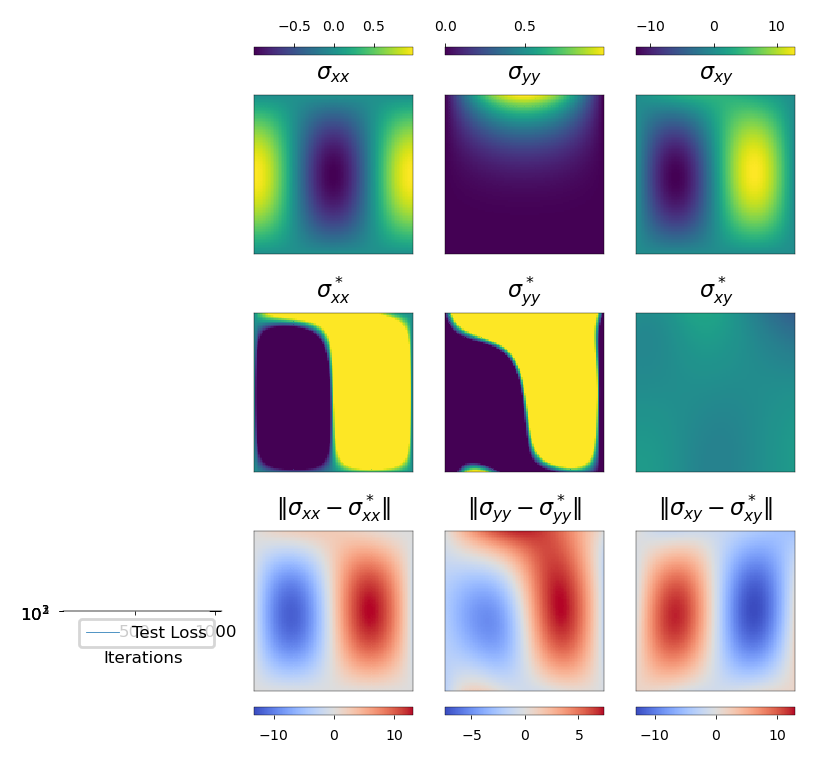

In [2]:
from ipywidgets import interact, IntSlider
from phd.models.cm.analytical_plate import get_animation_data, plot_results

saved_results = "results_notebook/forward_SPINN_1764168831"
# fig = plot_results(saved_results, iteration=-1)

fig = plot_results(saved_results, fields=["Ux", "Uy"], iteration=-1, dpi=200)
fig = plot_results(saved_results, fields=["Sxx", "Syy", "Sxy"], iteration=-1, dpi=200)


# def plot_interactive(iteration):
#     # Use the generic plot_results from plot_util which uses get_animation_data
#     # to adapt the results dictionary to the plotting format
#     fig = plot_results(saved_results, get_animation_data, iteration=iteration)
#     plt.show()

# # Get max steps from results to set slider range
# n_steps = 10
# interact(plot_interactive, iteration=IntSlider(min=0, max=n_steps-1, step=1, value=n_steps-1))


In [ ]:
import importlib
import phd.models.cm.analytical_plate
import phd.models.cm.plot_util
importlib.reload(phd.models.cm.plot_util)
importlib.reload(phd.models.cm.analytical_plate)
from phd.models.cm.analytical_plate import plot_results, get_animation_data

In [4]:
from phd.config import get_current_config
print(get_current_config())

PlottingConfig(page_width=120mm, scale=1.00, title_fs=8, axes_fs=6)


In [ ]:
# Generate Animation
from phd.models.cm.plot_util import animate
video_path_forward = run_dir_forward / "training_animation.mp4"
print("Generating animation...")

# Define exact solution function for the animation (using config parameters)
cfg = results_forward["config"]
exact_fn = lambda x: exact_solution(x, cfg["lmbd"], cfg["mu"], cfg["Q"], net_type=cfg["net_type"])

# Create animation using in-memory results
animate(results_forward, video_path_forward, get_animation_data, fps=10)

# print(f"Animation saved to {video_path_forward}")

Generating animation...


KeyError: (slice(None, None, None), slice(0, 1, None))

In [ ]:
get_animation_data

In [ ]:
# Display Training Animation
Video(video_path_forward, embed=True, html_attributes="controls loop autoplay")

In [ ]:
# Save Run Data
from phd.models.cm.analytical_plate import save_run_data
print("Saving run data to disk...")
save_run_data(results_forward)
print(f"Data saved to {run_dir_forward}")

### Workflow Flexibility
The workflow demonstrated above allows for flexible experimentation:
1. **Train**: Run the training loop with `save_fields_to_disk=False` to keep data in memory.
2. **Visualize**: Inspect results immediately using `plot_results` or `create_animation`.
3. **Save**: If the run is successful, persist the data using `save_run_data`.

This can all be controlled via the configuration dictionary passed to `train()`.

## Inverse Problem
We train the model to discover material parameters ($\lambda, \mu$) from synthetic data.

In [ ]:
# Configure and Train Inverse Model
config_inverse = {
    "task": "inverse",
    "n_iter": 2000,
    "log_every": 100,
    "generate_video": False, # Manual generation
    "save_fields_to_disk": False, # Keep in memory
    "results_dir": "results_notebook",
    "net_type": "SPINN",
    "lmbd_init": 2.0, # Initial guess
    "mu_init": 0.3,   # Initial guess
    "lmbd": 1.0,      # Target
    "mu": 0.5,        # Target
    "n_DIC": 10       # Number of DIC points (10x10)
}

print("Training Inverse Model...")
results_inverse = train(config_inverse)
run_dir_inverse = Path(results_inverse["run_dir"])
print(f"Training complete. Results available in memory.")

### Inverse Results Visualization

In [ ]:
# Generate Animation for Inverse Problem
video_path_inverse = run_dir_inverse / "training_animation.mp4"
print("Generating animation...")

# Exact solution uses the TRUE parameters (targets)
cfg_inv = results_inverse["config"]
exact_fn_inv = lambda x: exact_solution(x, cfg_inv["lmbd"], cfg_inv["mu"], cfg_inv["Q"], net_type=cfg_inv["net_type"])

create_animation(
    results_inverse, 
    video_path_inverse,
    exact_fn_inv,
    fps=10
)
print(f"Animation saved to {video_path_inverse}")

In [ ]:
# Display Inverse Training Animation
Video(video_path_inverse, embed=True, html_attributes="controls loop autoplay")

In [ ]:
# Save Inverse Run Data
print("Saving inverse run data to disk...")
save_run_data(results_inverse)
print(f"Data saved to {run_dir_inverse}")

In [ ]:
# Static Plot of Parameter Evolution
# We can load from disk now that we saved it, or use the results dict if we implemented parsing for it
# For now, let's load from disk as we just saved it
data_inverse = load_run_data(run_dir_inverse)
vars_hist = data_inverse["variable_values"]
vars_steps = data_inverse["variable_steps"]

plt.figure(figsize=(10, 5))
plt.plot(vars_steps, vars_hist[:, 0], label=r"$\lambda$ (Pred)")
plt.axhline(cfg_inv["lmbd"], color='b', linestyle='--', label=r"$\lambda$ (True)")
plt.plot(vars_steps, vars_hist[:, 1], label=r"$\mu$ (Pred)")
plt.axhline(cfg_inv["mu"], color='orange', linestyle='--', label=r"$\mu$ (True)")
plt.legend()
plt.title("Parameter Discovery Evolution")
plt.xlabel("Steps")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)
plt.show()